In [ ]:
# a=np.array([[1,2,3],[1,4,5]])
# a.mean(axis=0)
# axis = 0, only to gain the mean for each column

In [52]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.optimize as opt
import numpy.linalg as lin
import scipy.integrate as intgr
import matplotlib
from matplotlib import cm
from numpy import exp as exp



%matplotlib notebook

# load the incomes data
data = np.loadtxt('incomes.txt')




<IPython.core.display.Javascript object>


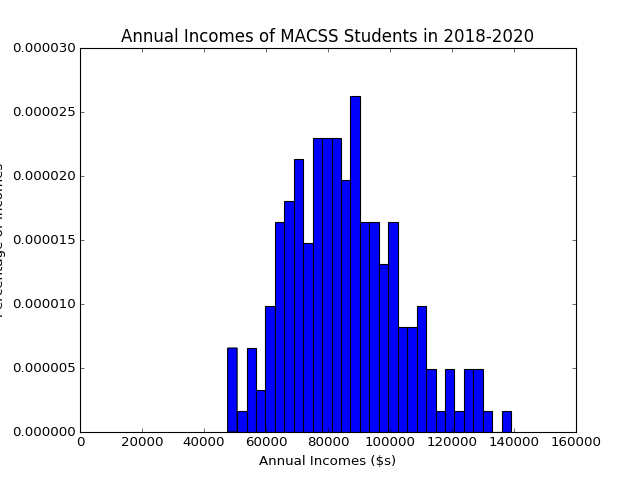

(0, 160000)

In [2]:
# a) plot the histogram 
num_bins = 30
# Plot the histogram for the annual incomes
fig, ax = plt.subplots()
# Plot the histogram for the annual incomes
count, bins, ignored = plt.hist(data, num_bins, normed=True)

# Label the plots
plt.title('Annual Incomes of MACSS Students in 2018-2020', fontsize=15)
plt.xlabel(r'Annual Incomes (\$s)')
plt.ylabel(r'Percentage of Incomes')

# Set the Limit of x-axis
plt.xlim([0,160000])



# save the picture
#output_path = os.path.join(output_dir, 'Fig_1a')
#plt.savefig(output_path, bbox_inches='tight')
#plt.close()

In [10]:
# Define function for lognormal pdf as LN_pdf()
def LN_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the lognormal pdf with mean mu and standard
    deviation sigma. This function does the same
    thing as sp.stats.norm.pdf(x, loc=mu, scale=sigma) for any given 
    data set with 1 dimension or 2 dimension.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the lognormally distributed random
             variable
    mu     = scalar, mean of the lognormally distributed random variable
    sigma  = scalar > 0, standard deviation of the lognormally distributed
             random variable

    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''        
    pdf_vals    = (1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    
    return pdf_vals

# Test the LN_pdf () by the following parameter and data (xvals)
xvals = np.array([[200.0, 270.0], [180.0, 195.5]]) 
mu = 5.0
sigma = 1.0

print ('b) the calculated lognormal PDF for the testing data and given parameters is shown as below: \n',LN_pdf(xvals, mu, sigma))

b) the calculated lognormal PDF for the testing data and given parameters is shown as below: 
 [[ 0.0019079   0.00123533]
 [ 0.00217547  0.0019646 ]]


In [124]:
# c) 
def norm_draws(unif_vals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Draw (N x S) matrix of random draws from a normal
    distribution based on a lofnormal distribution with mean mu and
    standard deviation sigma . These draws correspond to an (N x S) 
    matrix of randomly generated draws from 
    a uniform distribution U(0,1).
    --------------------------------------------------------------------
    INPUTS:
    unif_vals = (N, S) matrix, (N,) vector, or scalar in (0,1), random
                draws from uniform U(0,1) distribution
    mu        = scalar, mean of the nontruncated normal distribution
                from which the truncated normal is derived
    sigma     = scalar > 0, standard deviation of the nontruncated
                normal distribution from which the truncated normal is
                derived
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        scipy.stats.lognorm()
    
    OBJECTS CREATED WITHIN FUNCTION:
    one_draws = (N, S) matrix, (N,) vector, or scalar in (0,1),
                  values drawn from truncated normal PDF with base
                  lognormal distribution N(mu, sigma) 
                  
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: one_draw
    --------------------------------------------------------------------
    '''
    one_draw = sts.norm.ppf(unif_vals, loc=mu, scale=sigma)
    return one_draw

# Another way to do that is to directly draw (N*S) by using the lognorma.ppf as below
# (Note: need scalar = exp(mu) rather than "mu")
# one_draw = sts.lognorm.ppf(unif_vals, scale = exp (mu), s = sigma)


def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for SMM
    (mean(data), std(data)) from both the actual data and from the
    simulated data.
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N, S) matrix, (N,) vector, or scalar in (cut_lb, cut_ub),
            test scores data, either real world or simulated. Real world
            data will come in the form (N,). Simulated data comes in the
            form (N,) or (N, S).
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar or (S,) vector, mean value of test scores data
    std_data  = scalar > 0 or (S,) vector, standard devition 
    of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    if xvals.ndim == 1:
        mean_data = xvals.mean()
        std_data = xvals.std()
    elif xvals.ndim == 2:
        mean_data = xvals.mean(axis=0)
        std_data = xvals.std(axis=0)
    
    return mean_data, std_data


def err_vec(data_vals, sim_vals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for SMM.
    --------------------------------------------------------------------
    INPUTS:
    data_vals = (N,) vector, test scores data
    sim_vals  = (N, S) matrix, S simulations of test scores data
    mu        = scalar, mean of the nontruncated normal distribution
                from which the truncated normal is derived
    sigma     = scalar > 0, standard deviation of the nontruncated
                normal distribution from which the truncated normal is
                derived
    simple    = boolean, =True if errors are simple difference, =False
                if errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    std_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, estimated mean value from model
    std_model  = scalar > 0, estimated variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(data_vals)
    
    moms_data = np.array([[mean_data], [std_data]])
    
    mean_sim, std_sim = data_moments(sim_vals)
    mean_model = mean_sim.mean()
    std_model = std_sim.mean()
    
    moms_model = np.array([[mean_model], [std_model]])
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the SMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params    = (2,) vector, ([mu, sigma])
    mu        = scalar, mean of the normally distributed random variable
    sigma     = scalar > 0, standard deviation of the normally
                distributed random variable
    args      = length  tuple,
                (xvals, unif_vals, cut_lb, cut_ub, W_hat)
    xvals     = (N,) vector, values of the truncated normally
                distributed random variable
    unif_vals = (N, S) matrix, matrix of draws from U(0,1) distribution.
                This fixes the seed of the draws for the simulations
    
    W_hat     = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        LN_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, unif_vals, W_hat = args
    sim_vals_norm = norm_draws(unif_vals, mu, sigma) # this is to get the normally distributed S*N draws
    sim_vals = np.exp(sim_vals_norm) # to convert (S*N) to log normal ditribution
    err = err_vec(xvals, sim_vals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W_hat), err) 
    
    return crit_val

c)
Mean of data= 85276.8236063 standard deviation of data= 17992.542128 ;
Mean of SMM1= 85276.8266105 standard deviation of SMM1= 17992.5418275 ;
Difference in mean= -0.00300425097521 Difference in std= 0.000300497536955 ;
mu_SMM1_1= 11.3306372212  sig_SMM1_1= 0.209229359913 ;
The value of SMM criterion function is  1.52004132708e-15 ;
Error Vector 1 = [  3.52293958e-08  -1.67012274e-08]


<IPython.core.display.Javascript object>


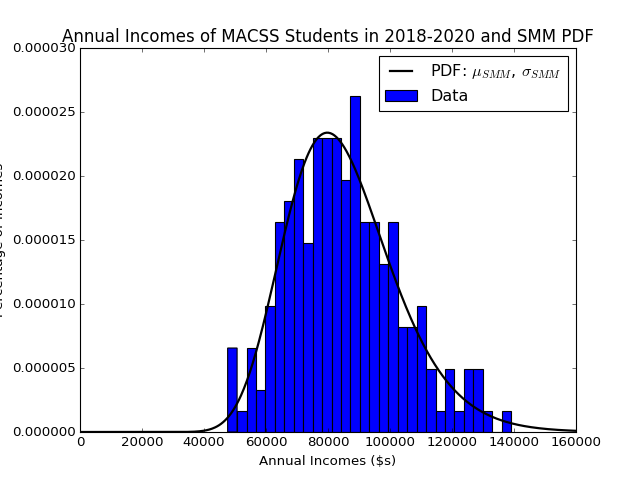

In [161]:
#set the seed to 1234 in the random number generator
np.random.seed(seed=1234)

# Set the draws number
N = 200
S = 300

# initialize the parameters mu and sigma
mu_1 = 11.3
sig_1 = 0.1

# draw the simulation data
unif_vals = sts.uniform.rvs(0, 1, size = (N, S))


# set the identity matrix "W_hat"
W_hat = np.eye(2)

# set the para and args for crierion function
params_init_1 = np.array([mu_1, sig_1])
smm_args1_1 = (data, unif_vals, W_hat)

# set the minimization method as 'L-BFGS-B'
results_1 = opt.minimize(criterion, params_init_1, args=(smm_args1_1),
                          method='L-BFGS-B',
                          bounds=((1e-10, None), (1e-10, None)))
mu_SMM1, sig_SMM1 = results_1.x

# Analysis of Results
crt = criterion((mu_SMM1, sig_SMM1), data, unif_vals, W_hat)
mu_data, sig_data= data_moments(data)
# to draw the simulated data by using the SMM optimized mu and sigma
sim_vals = np.exp(norm_draws(unif_vals, mu_SMM1, sig_SMM1)) 
mean_sim, std_sim = data_moments(sim_vals)
mean_model = mean_sim.mean()
std_model = std_sim.mean()
err_1 = err_vec(data, sim_vals, mu_SMM1, sig_SMM1, False).reshape(2,)


print('c)')
print('Mean of data=', mu_data, 'standard deviation of data=', sig_data, ';')
print('Mean of SMM1=',mean_model , 'standard deviation of SMM1=', std_model , ';')
print('Difference in mean=', mu_data - mean_model, 'Difference in std=', sig_data - std_model, ';')
print('mu_SMM1_1=', mu_SMM1, ' sig_SMM1_1=', sig_SMM1, ';')
print('The value of SMM criterion function is ', crt[0][0], ';')
print ('Error Vector 1 =', err_1)

# plotting pdf of the SMM estimated model and histogram of orignal data 
count_d, bins_d, ignored_d = \
    plt.hist(data, 30, normed=True, color='b', label='Data')
xvals = np.linspace(0, 160000, 500)
plt.plot(xvals, LN_pdf(xvals, mu_SMM1,sig_SMM1),
         linewidth=2, color='k', label='PDF: $\mu_{SMM}$, $\sigma_{SMM}$')
plt.title('Annual Incomes of MACSS Students in 2018-2020 and SMM PDF', fontsize=15)
plt.xlabel(r'Annual Incomes (\$s)')
plt.ylabel(r'Percentage of Incomes')
plt.xlim([0, 160000])  # This gives the xmin and xmax to be plotted"
plt.legend(loc='upper right')    
    

d)
Mean of data= 85276.8236063 standard deviation of data= 17992.542128 ;
Mean of SMM2= 85276.8198373 standard deviation of SMM2= 17992.5405425 ;
Difference in mean= 0.00376898607647 Difference in std= 0.00158551204368 ;
mu_SMM2_2= 11.3306371414  sig_SMM2_2= 0.209229361554 ;
The value of SMM criterion function is  0.630049923211 ;
Error Vector in 2 step SMM = [  3.52293958e-08  -1.67012274e-08]


<IPython.core.display.Javascript object>


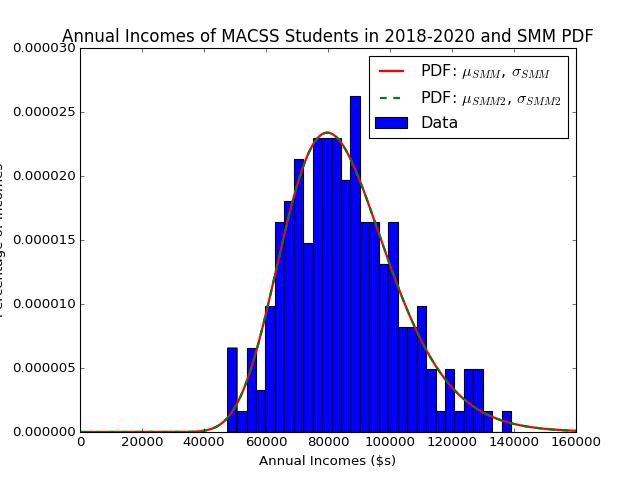

In [167]:
# d) 
# obtain the error vector for 2-step optimization,
# by using original data and simulated data and optimized parameters
err2 = err_vec(data, sim_vals, mu_SMM1, sig_SMM1, False)
VCV2 = np.dot(err2, err2.T) / data.shape[0]
W_hat2 = lin.pinv(VCV2) 
# print(W_hat2)

params_init2 = np.array([mu_SMM1, sig_SMM1])
smm_args2 = (data, unif_vals, W_hat2)
results2 = opt.minimize(criterion, params_init2, args=(smm_args2),
                         method='L-BFGS-B',
                         bounds=((1e-10, None), (1e-10, None)))
mu_SMM2, sig_SMM2 = results2.x


# Analysis of Results
crt_2 = criterion((mu_SMM2, sig_SMM2), data, unif_vals, W_hat2)
# to draw the simulated data by using the SMM-2 step optimized mu and sigma 
sim_vals_2 = np.exp(norm_draws(unif_vals, mu_SMM2, sig_SMM2)) 
mean_sim_2, std_sim_2 = data_moments(sim_vals_2)
mean_model_2 = mean_sim_2.mean()
std_model_2 = std_sim_2.mean()
err_2 = err_vec(data, sim_vals, mu_SMM2, sig_SMM2, False).reshape(2,)


print('d)')
print('Mean of data=', mu_data, 'standard deviation of data=', sig_data, ';')
print('Mean of SMM2=',mean_model_2 , 'standard deviation of SMM2=', std_model_2 , ';')
print('Difference in mean=', mu_data - mean_model_2, 'Difference in std=', sig_data - std_model_2, ';')
print('mu_SMM2_2=', mu_SMM2, ' sig_SMM2_2=', sig_SMM2,';')
print('The value of SMM criterion function is ', crt_2[0][0], ';')
print ('Error Vector in 2 step SMM =', err_2)

## Find indeed there is no significant improvement in the 2-step optimization


# plotting pdf of the SMM estimated model and histogram of orignal data 
count_d, bins_d, ignored_d = \
    plt.hist(data, 30, normed=True, color='b', label='Data')
    
xvals = np.linspace(0, 160000, 500)
plt.plot(xvals, LN_pdf(xvals, mu_SMM1,sig_SMM1),
         linewidth=2, color='r', label='PDF: $\mu_{SMM}$, $\sigma_{SMM}$')
plt.plot(xvals, LN_pdf(xvals, mu_SMM2,sig_SMM2),'--',
         linewidth=2, color='g', label='PDF: $\mu_{SMM2}$, $\sigma_{SMM2}$')

plt.title('Annual Incomes of MACSS Students in 2018-2020 and SMM PDF', fontsize=15)
plt.xlabel(r'Annual Incomes (\$s)')
plt.ylabel(r'Percentage of Incomes')
plt.xlim([0, 160000])  # This gives the xmin and xmax to be plotted"
plt.legend(loc='upper right')   




In [165]:
# if changing to other method 'SLSQP'
results2 = opt.minimize(criterion, params_init2, args=(smm_args2),
                         method='SLSQP',
                         bounds=((1e-10, None), (1e-10, None)))
mu_SMM2, sig_SMM2 = results2.x


# Analysis of Results
crt_2 = criterion((mu_SMM2, sig_SMM2), data, unif_vals, W_hat2)
# to draw the simulated data by using the SMM-2 step optimized mu and sigma 
sim_vals_2 = np.exp(norm_draws(unif_vals, mu_SMM2, sig_SMM2)) 
mean_sim_2, std_sim_2 = data_moments(sim_vals_2)
mean_model_2 = mean_sim_2.mean()
std_model_2 = std_sim_2.mean()
err_2 = err_vec(data, sim_vals, mu_SMM2, sig_SMM2, False).reshape(2,)


print('By using SLSQP minimization method')
print('Mean of data=', mu_data, 'standard deviation of data=', sig_data, ';')
print('Mean of SMM2=',mean_model_2 , 'standard deviation of SMM2=', std_model_2 , ';')
print('Difference in mean=', mu_data - mean_model_2, 'Difference in std=', sig_data - std_model_2, ';')
print('mu_SMM2_2=', mu_SMM2, ' sig_SMM2_2=', sig_SMM2,';')
print('The value of SMM criterion function is ', crt_2[0][0], ';')
print ('Error Vector in 2 step SMM =', err_2)

By using 
Mean of data= 85276.8236063 standard deviation of data= 17992.542128 ;
Mean of SMM2= 85276.8266105 standard deviation of SMM2= 17992.5418275 ;
Difference in mean= -0.00300425097521 Difference in std= 0.000300497536955 ;
mu_SMM2_2= 11.3306372212  sig_SMM2_2= 0.209229359913 ;
The value of SMM criterion function is  200.0 ;
Error Vector in 2 step SMM = [  3.52293958e-08  -1.67012274e-08]


array([  3.52293958e-08,  -1.67012274e-08])